In [15]:
import sys
sys.path.append('classical')

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [22]:
XI_coefficient = 1/np.sqrt(2)
ZI_coefficient = 1/1
beta = 5
sigma = np.zeros([2, 2, 4], dtype=complex)
sigma[0, 0, 0] = 1.
sigma[1, 1, 0] = 1.
sigma[0, 1, 1] = 1.
sigma[1, 0, 1] = 1.
sigma[0, 1, 2] = -1j
sigma[1, 0, 2] = 1j
sigma[0, 0, 3] = 1.
sigma[1, 1, 3] = -1.
N = 50 # Number of imaginary time steps
db = beta / N
# Defining the Hamiltonian
Hamiltonian = XI_coefficient * np.kron(sigma[:, :, 1], sigma[:, :, 0]) + \
              ZI_coefficient * np.kron(sigma[:, :, 3], sigma[:, :, 0])

In [23]:
# Classical trajectory

# List to store energy values
energy_classical_list = []
energy_qite_list = []

# Perform imaginary time evolution
for i in range(0,N):

    # Construct Gibbs state
    gibbs = expm(-(i + 1) * db * Hamiltonian)
    gibbs = gibbs / np.trace(gibbs)
    
    # Compute energy and store values at each step
    energy_classical_list.append(np.real(np.trace(np.matmul(gibbs, Hamiltonian))))

## QITE Approximation

In [24]:
# First populate the Lie algebra rules
index = np.zeros([4**2,4**2],dtype=int)
coeff = np.zeros([4**2,4**2],dtype=complex)

row = 0
for i in range(4**2):
    column = 0
    for j in range(4**2):
        Pnu = Opp2Str(Int2Bas(column,4,2))
        Pmu = Opp2Str(Int2Bas(row,4,2))
        A = Pmu[0] + Pnu[0]
        B = Pmu[1] + Pnu[1]
        A,intA = PPmunu(A)
        B,intB = PPmunu(B)
        index[i,j] = Bas2Int(Str2Opp(A+B),4)
        coeff[i,j] = intA*intB
        column += 1
    row += 1
    
print(index)
print(coeff)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 1  0  3  2  5  4  7  6  9  8 11 10 13 12 15 14]
 [ 2  3  0  1  6  7  4  5 10 11  8  9 14 15 12 13]
 [ 3  2  1  0  7  6  5  4 11 10  9  8 15 14 13 12]
 [ 4  5  6  7  0  1  2  3 12 13 14 15  8  9 10 11]
 [ 5  4  7  6  1  0  3  2 13 12 15 14  9  8 11 10]
 [ 6  7  4  5  2  3  0  1 14 15 12 13 10 11  8  9]
 [ 7  6  5  4  3  2  1  0 15 14 13 12 11 10  9  8]
 [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
 [ 9  8 11 10 13 12 15 14  1  0  3  2  5  4  7  6]
 [10 11  8  9 14 15 12 13  2  3  0  1  6  7  4  5]
 [11 10  9  8 15 14 13 12  3  2  1  0  7  6  5  4]
 [12 13 14 15  8  9 10 11  4  5  6  7  0  1  2  3]
 [13 12 15 14  9  8 11 10  5  4  7  6  1  0  3  2]
 [14 15 12 13 10 11  8  9  6  7  4  5  2  3  0  1]
 [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]]
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j
   1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0.+1.j  0.-1.j  1.+0.j  1.+0.j 

In [25]:
# QITE trajectory

phi = np.zeros([4], dtype=complex)
phi[0] = 1.
phi[3] = 1.
phi = phi/np.linalg.norm(phi)

debug_Pmu_expectation_list = []

print('We start QITE now')
for i in range(0,N):

    # First construct Pmu_expectation matrices
    Pmu_expectation = np.zeros([16], dtype=complex)
    for Pmu in range(2**4):
        ops = Int2Bas(Pmu, 4, 2)
#         print("ops: ", ops)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        Pmu_expectation[Pmu] = np.matmul(np.transpose(np.conj(phi)), np.matmul(operator, phi))
        
    debug_Pmu_expectation_list.append(Pmu_expectation.real.tolist())

    # Now construct S matrix
    #propagation_strings = [2, 6, 8, 9, 11, 14]
    propagation_strings = list(range(16))
    S = np.zeros([len(propagation_strings), len(propagation_strings)], dtype=complex)
    for i, ops1 in enumerate(propagation_strings):
        for j, ops2 in enumerate(propagation_strings):
            S[i,j] = Pmu_expectation[index[ops1, ops2]]*coeff[ops1, ops2]

    # Now construct b vector
    b = np.zeros([len(propagation_strings)], dtype=complex)
    
    # Compute norm
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    c = np.exp(- (db/2) * e)

    for i, ops1 in enumerate(propagation_strings):
        b[i] -= (XI_coefficient) * coeff[ops1, 1] * Pmu_expectation[index[ops1, 1]]
        b[i] -= (ZI_coefficient) * coeff[ops1, 3] * Pmu_expectation[index[ops1, 3]]
        b[i] = -2  * np.imag(b[i]) * (db / 2) / c
    # Obtain x 
    dalpha = np.eye(len(propagation_strings)) * 0.1
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]

    # Classical evolution
    U = np.eye(4)
    for i, ops1 in enumerate(propagation_strings):
        ops = Int2Bas(ops1, 4, 2)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        U = np.matmul(expm(1j * x[i] * operator), U)
    phi = np.matmul(U, phi)
    
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_qite_list.append(e)

print(debug_Pmu_expectation_list)


We start QITE now
[[0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.9999999999999998, 0.0, 0.0, 0.0, 0.0, -0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.9999999999999998], [0.9999999999999989, -0.06876742770417325, -1.5793024350750746e-17, -0.0973483429851782, -0.06876742770417324, 0.9952447016159576, 1.0023325957521366e-17, 0.0033591700465422994, 1.4238062276311756e-17, 8.987052266883353e-18, -0.9928717646327694, 8.46824082866448e-18, -0.0973483429851782, 0.0033591700465423063, 9.935207531224789e-18, 0.9976270630168107], [0.9999999999999991, -0.1355162755602294, -5.007208230311846e-17, -0.192003102787292, -0.1355156338898113, 0.9813055721808334, 3.0338823421129478e-18, 0.013191232457168342, 3.6401556467327026e-17, -2.9083781513963798e-18, -0.9719928742425711, 6.594832646437711e-17, -0.19200355567828958, 0.01319782280899802, 7.436784317017718e-17, 0.9906873020507243], [0.9999999999999989, -0.19854429885552743, -4.3243597519270227e-17, -0.2815212948820412, -0.19853987571471582, 0.9591213416384208

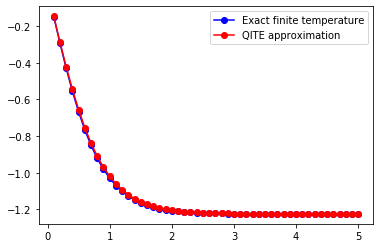

In [26]:
plt.figure()
beta_list = np.asarray(range(1, N+1)) * db
plt.plot(beta_list, energy_classical_list, '-bo', label='Exact finite temperature')
plt.plot(beta_list, energy_qite_list, '-ro', label='QITE approximation')
plt.legend()
plt.show()